In [1]:
import pennylane as qml
import numpy as np
from pennylane.templates import ApproxTimeEvolution

from pyqsp.pyqsp.angle_sequence import QuantumSignalProcessingPhases
from pyqsp.pyqsp.response import PlotQSPResponse
from pyqsp.pyqsp.poly import TargetPolynomial

from QSVTPolynomial import QSVTPolynomial
import warnings
warnings.filterwarnings('ignore')

system_qubits = [0, 1, 2]
rotation_qubit = 'rotation'
signal_qubit = 'signal'
ancilla_qubit = 'ancilla'
qsvt_wires = [rotation_qubit, signal_qubit] + system_qubits
all_wires = [ancilla_qubit] + qsvt_wires
force_parity = 'even'
ang_seq = []
delta = 0.01
dev = qml.device("default.qubit", wires=all_wires)

init_coeffs = np.array([1, 1, 1])
alpha = np.linalg.norm(init_coeffs) + 1
coeffs = init_coeffs/(alpha)
obs = [qml.PauliZ(0), qml.PauliZ(1), qml.PauliZ(2)]
H = qml.Hamiltonian(coeffs, obs) # type: ignore
print("Eigenvalues: ", np.array(qml.eigvals(H)))
exact_eigenvalues = np.array(qml.eigvals(H))

Eigenvalues:  [-1.09807621 -0.3660254  -0.3660254  -0.3660254   0.3660254   0.3660254
  0.3660254   1.09807621]


In [2]:
def U():
    rotation_qubit = signal_qubit
    qml.Hadamard(rotation_qubit)
    #qml.broadcast(qml.Hadamard, wires= system_qubits + [rotation_qubit], pattern="single")
    qml.ctrl(ApproxTimeEvolution(H, 1, 1), control=rotation_qubit)
    qml.Hadamard(rotation_qubit)
    #qml.broadcast(qml.Hadamard, wires= system_qubits + [rotation_qubit], pattern="single")

def U_adjoint():
    rotation_qubit = signal_qubit
    #qml.broadcast(qml.Hadamard, wires= system_qubits + [rotation_qubit], pattern="single")
    qml.Hadamard(rotation_qubit)
    qml.adjoint(qml.ctrl(ApproxTimeEvolution(H, 1, 1), control=rotation_qubit))
    qml.Hadamard(rotation_qubit)
    #qml.broadcast(qml.Hadamard, wires= system_qubits + [rotation_qubit], pattern="single")

In [3]:
"""from utils import bmatrix
from IPython.display import Latex, display

display(
    Latex(
        bmatrix(
            np.around(
                np.real(
                    np.array(
                        qml.matrix(U)())), 6)))) # type: ignore"""

'from utils import bmatrix\nfrom IPython.display import Latex, display\n\ndisplay(\n    Latex(\n        bmatrix(\n            np.around(\n                np.real(\n                    np.array(\n                        qml.matrix(U)())), 6)))) # type: ignore'

##### Computing the coefficients from the polynomial

Eigenvalue treshold polynomial

$$ P^{\text{ET}}_{\epsilon, \Delta, \lambda_{\text{th}}/\alpha}(x) = \frac{1}{1 + \frac{\epsilon}{4}}\left( -1 + \frac{\epsilon}{4} + P^{\Theta}_{\frac{\epsilon}{2}, \Delta}(\frac{\lambda_{\text{th}}}{\alpha} - x) + P^{\Theta}_{\frac{\epsilon}{2}, \Delta}(\frac{\lambda_{\text{th}}}{\alpha} + x) \right)$$

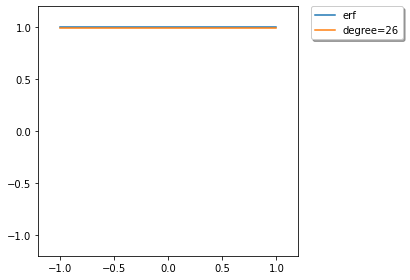

In [4]:
threshold = 10
modified_threshold = 0.5*(threshold/alpha + 1)
P = QSVTPolynomial(modified_threshold, 3, delta = delta/4, force_parity = force_parity)
polynomial = P.get_threshold_polynomial()
P.plot(polynomial)

In [5]:
np.polynomial.Chebyshev(polynomial)

Chebyshev([ 9.95001562e-01,  0.00000000e+00, -1.97311322e-16,  0.00000000e+00,
       -4.60393086e-16,  0.00000000e+00, -7.89245289e-16,  0.00000000e+00,
       -1.20853185e-15,  0.00000000e+00, -1.56204797e-15,  0.00000000e+00,
       -2.07176888e-15,  0.00000000e+00, -3.18986638e-15,  0.00000000e+00,
       -4.55460302e-15,  0.00000000e+00, -3.18600236e-15,  0.00000000e+00,
       -2.40062109e-15,  0.00000000e+00, -3.66670207e-15,  0.00000000e+00,
       -2.80346504e-15,  0.00000000e+00, -1.35651534e-15], domain=[-1,  1], window=[-1,  1])

In [6]:
%%capture
# Include %%capture because of many warnings from tensorflow
# Using tensorflow (tf) to find the phases
# Slow but should be accurate and also seems to be handling longer polynomials
ang_seq = np.array(QuantumSignalProcessingPhases(polynomial, 
                                                signal_operator="Wx", 
                                                method = "tf")).flatten()

In [7]:
ang_seq

array([-1.2205846 ,  2.9206955 ,  5.4653797 ,  1.126456  ,  1.5444591 ,
        5.1330643 ,  0.86564213,  4.900541  ,  1.4707305 ,  1.3690869 ,
        1.584129  ,  0.19438323,  1.3286012 ,  0.52545035, -0.15238196,
        1.6302255 ,  0.24779189,  2.6113427 ,  2.1306853 ,  1.2705718 ,
        1.2362713 ,  1.9100021 ,  0.7463905 ,  1.590215  , -0.1783342 ,
        1.614879  ,  2.208912  ], dtype=float32)

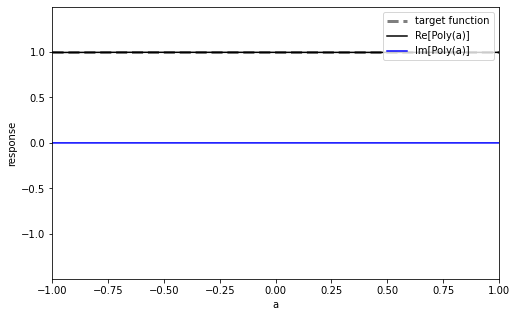

In [8]:
poly = TargetPolynomial(polynomial)
PlotQSPResponse(ang_seq, target=poly, signal_operator="Wx")

In [9]:
def left_controlled_phase_sift(phi):
    control_wires = system_qubits + [signal_qubit]
    qml.ControlledQubitUnitary(qml.RZ(phi, rotation_qubit),
                               control_wires = control_wires,
                               wires = control_wires + [rotation_qubit],
                               control_values = '0'*(len(system_qubits) + 1))
    

def right_controlled_phase_sift(phi):
    control_wires = system_qubits + [signal_qubit]
    qml.ControlledQubitUnitary(qml.RZ(phi, rotation_qubit),
                               control_wires = control_wires,
                               wires = control_wires + [rotation_qubit],
                               control_values = '0'*(len(system_qubits) + 1))

In [10]:
@qml.qnode(dev)
def full_circuit_odd(angles):

    # Prepare the system qubits into |phi> state
    # This state is the representation of the state in eigenbasis of the Hamiltonian
    ApproxTimeEvolution(H, 1, 1)
    
    # Ancilla qubit is prepared in |+> state
    qml.Hadamard(ancilla_qubit)

    # Making QSVT operator controlled by the ancilla qubit
    for target in [rotation_qubit, signal_qubit] + system_qubits:
        qml.CNOT(wires=['ancilla', target])
    
    left_controlled_phase_sift(angles[0])
    U()

    for i in range((len(angles) - 1)//2):
        #print(2*i, 2*i + 1)
        right_controlled_phase_sift(angles[2*i])
        U_adjoint()
        left_controlled_phase_sift(angles[2*i + 1])
        U()

    for target in [rotation_qubit, signal_qubit] + system_qubits:
        qml.CNOT(wires=['ancilla', target])
        
    qml.Hadamard(ancilla_qubit)

    return qml.probs('ancilla')

In [11]:
@qml.qnode(dev)
def full_circuit_even(angles):

    # Prepare the system qubits into |phi> state
    # The state is in the eigenbasis of the Hamiltonian
    ApproxTimeEvolution(H, 1, 1)
    
    # Ancilla qubit is prepared in |+> state
    qml.Hadamard(ancilla_qubit)

    # Making the QSVT operator controlled by the ancilla qubit
    for target in system_qubits:
        qml.CNOT(wires=['ancilla', target])

    # Apply QSVT
    for i in range(len(angles)//2):
        #print(2*i + 1, 2*i + 2)
        right_controlled_phase_sift(angles[2*i + 1])
        U_adjoint()
        left_controlled_phase_sift(angles[2*i + 2])
        U()
        
    for target in system_qubits:
        qml.CNOT(wires=['ancilla', target])
        
    qml.Hadamard(ancilla_qubit)

    return qml.probs('ancilla')

[0.14981471 0.85018529]
Correct result:  0
Predicted result from QSVT:  1


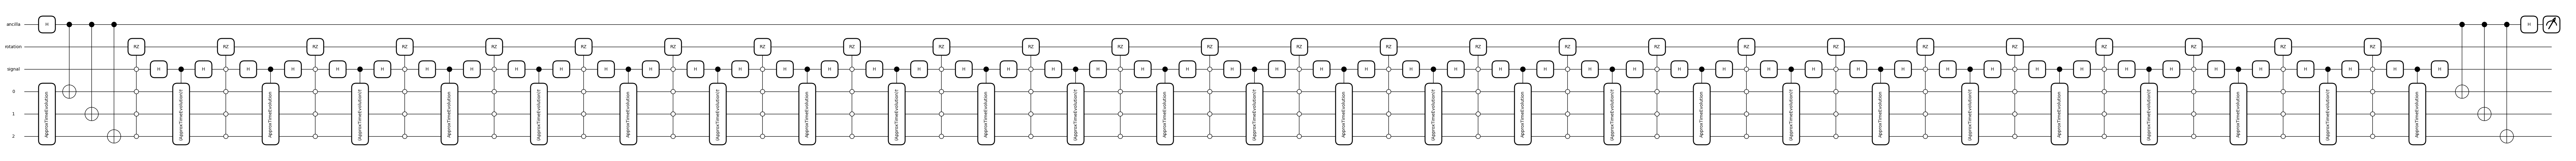

In [12]:
prediction = []
if force_parity == 'even':
    prediction = full_circuit_even(ang_seq)
    qml.draw_mpl(full_circuit_even)(ang_seq)
else:
    prediction = full_circuit_odd(ang_seq)
    qml.draw_mpl(full_circuit_odd)(ang_seq)

# Print true if all the eigenvalues are above the threshold
print(prediction)
predicted_result = np.argmax(prediction)
print("Correct result: ", int(np.all(exact_eigenvalues > threshold)))
print("Predicted result from QSVT: ", predicted_result)

In [13]:
print(1/2*(delta/2)**2)
print(delta**2*(1 - delta/4))
print(delta**2/32)

1.25e-05
9.975000000000001e-05
3.125e-06
